# Describing the problem & goals of this test

### Task & data

I chose sequence to expression task because the random promoter data recently generated by Carl de Boer lab allow us to quickly prototype and determine model architectures that are capable of predicting gene expression readout. This data describes transcriptional activity of just one yeast cell state but across 10 million random sequences which explore regulatory sequence space more deeply than you could by training models on the natural yeast genome. It was formatted in a way that makes it convenient to start with, whereas majority of problems relevant to perturbing aged and disfunctional cell states would require analysis and processing likely to take months to optimise. This makes this data a convenient starting point.

An important caveat is that the models optimised to perform well on this data would quite possibly not perform optimally for predicting total RNA abundance in human, mouse and other ageing-relevant model organisms because these organisms have more cell types and more complex regulation than yeast (yeast scRNA https://www.nature.com/articles/s42003-021-02320-w, not that many regulatory states https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000224). The required specificity of transcription in vertebrates is going to require both 1) more complex interactions between transcription factors that bind to the promoter sequence near the transcription start site and 2) more complex interactions between transcription factors binding to the promoter and binding to the distal regulatory sites (the regulation become more complex at the origin of multicellularity 10.1016/j.cell.2016.03.034 and in general enabled complexity increase https://pubmed.ncbi.nlm.nih.gov/37390583/).

In addition, yeast don't have complex 3D genome organisation such as TAD domains and have more limited utilisation of activity associated compartments. It is also likely that major gene regulation rules responsible for specification of cell states are different in vertebrates compared to yeast (active area of study, for example by Arnau Sebe-Pedros, Heather Marlow labs). However, a model that will succeed in mammals should likely be sufficiently complex to deal with this relatively simple data. Therefore, this data provides a quick test of model architecture robustness.

The additional problem with this task is that to explain how the same genome is used by and leads to different cell states, we need to consider not just the genome sequence but which transcription factors and other regulatory proteins are present in those cell states. In contrast, this data presents the genome as if it was a static entity that always leads to the same activity. This task is not a realistic task necessary for identifying how to perturb aged or dysfunctional cells.

### Bayesian modelling, CNN & what is tested here

Bayesian modelling is not very frequently used in industry for large scale models. However, it provides a principled and intuitive way to include prior information about biology as inductive biases on model parameters - in addition to providing inductive biases in model architecture. In addition, there are statistical arguments why maximum likelihood inference leads to suboptimal solution for high-dimensional problems and where estimating variational posterior could lead to estimates that are closer to ground truth.

Even when Bayesian models are not used with parameters informed by measurements external to the training task, the priors can be useful for specifying reasonable ranges of values and default behavior of the model. For example, if we want to learn assay sensitivity, we may want to regularize the parameter that represents assay sensitivity to be close to 1 to avoid over-normalizing biological differences. Similarly, we can regularise convolutional neural network weights that represent transcription factor DNA recognition preference to be either 1) small, thus implicitly requesting the model to learn simpler motifs, or 2) similar to experimentally determined motifs for transcription factors, which are extremely well characterized in yeast, so should provide a very good reference for this model. Both settings are tested in this experiment.

In this task, we are going to train a simple Bayesian conditional neural network, which predicts the same outputs as the winning solution of the random promoter challenge. Winning solution of defined a dual likelihood for MPRA data that didn't just predict estimated average sequence activity (output of pre-processing workflow), but also predicted in which of the FACS bins a signal will be observed. The winning approach uses the inductive bias about how the experiment was designed, predicting which sequences are detected in which FACS sorting bins. FACS sorting was done according to reporter protein fluorescence - an approach where the measurement for every sequence is not readout on a continous scale but instead quantified in bins. In general, MPRA technologies with both sequencing and FACS readout could benefit from better formalized likelihoods that don't require arbitrary preprocessing of experimentally measured values (we could collaborate with Lars Velten, Jay Shendure labs to optimise this).

Since this data is quite simple, representing both one cell state and yeast, an organism with relatively simple regulation, we likely don't need very complex models such as Enformer or deep CNN to represent the underlying mechanisms, and we can use a simple two-layer convolutional neural network with Bayesian parameters.

### Baselines

Three kinds of baselines would be useful:
1. Trivial memorisation baseline such as computing average signal for the same sequence per experimental batch ignoring cell type.
2. Best possible performance memorisation baseline such as replicate concordance or computing average signal for the same sequence per cell type.
3. Previously published packages (architecture + implementation). This helps understand how methods that worked and were published on other data look on this data.

When the task ignores cell states and only considers DNA, we need to consider baselines that test whether the model learns trivial or technically-driven pattern in DNA sequences - instead of learning the regulatory code of interest. This test is partially achieved by testing on previously unseen DNA sequences which can rule out severe overfitting to training sequences. 

It is easier to construct a best possible performance baseline using biological and/or technicical replicates - which as far as I can see is not easily accessible for this data. Constructing an alternative model that optimally prepresent sequence patterns is the modelling goal in itself

We are left with trivial baselines such as:
1. Using CG dinucleotide (aka k=2 K-mer) content as a predictor.
2. Computing the average signal for N most similar training sequences with similar k-mer compositions (eg k=1...4).

NOTE: I don't know why the authors of the underlying package did not use PyTorch Lightning but implemented their own trainers. I just used ther core package. In a real project I would use scvi-tools and PyTorch Lightning.
NOTE 2: the code seems to be limited by batch loading rather than GPU compute.

#### Install environment

```bash
export PYTHONNOUSERSITE="aaaaa"
conda env create -n dream -f environment.yml
conda activate dream
python -m ipykernel install --user --name=dream --display-name='Environment (dream)'
```

```bash
export PYTHONNOUSERSITE="aaaaa"
conda env create -n dream2 -f environment.yml
conda activate dream2
python -m ipykernel install --user --name=dream2 --display-name='Environment (dream2)'
```

#### Load JASPAR motifs

```bash
wget https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
```

# Import libraries and functions

In [1]:
import pandas as pd
import torch
import numpy as np
import os
from prixfixe.autosome import AutosomeDataProcessor, AutosomeFinalLayersBlock, AutosomeTrainer, AutosomePredictor
from prixfixe.bhi import BHIFirstLayersBlock, BHICoreBlock
from prixfixe.unlockdna import UnlockDNACoreBlock
from prixfixe.prixfixe import PrixFixeNet
from prixfixe.bayesian import BayesianFinalLayersBlock, BayesianTrainer, setup_pyro_model, get_jaspar_motifs, motif_dict_to_array

/nfs/team283/vk7/software/miniconda3farm5/envs/dream/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize paths and variables

In [2]:
# TRAIN_DATA_PATH = "data/demo_train.txt" #change filename to actual training data
# VALID_DATA_PATH = "data/demo_val.txt" #change filename to actual validaiton data
TRAIN_DATA_PATH = "../train.txt" # 6065325
VALID_DATA_PATH = "../val.txt" #change filename to actual validaiton data


TRAIN_BATCH_SIZE = 8192 # replace with 1024, if 1024 doesn't fit in gpu memory, decrease by order of 2 (512,256)
BATCH_PER_EPOCH = int(np.ceil(6065325 / TRAIN_BATCH_SIZE)) #replace with total amount of possible batches in the training data
N_PROCS = 4
VALID_BATCH_SIZE = 8192
BATCH_PER_VALIDATION = int(np.ceil(673925 / VALID_BATCH_SIZE)) #replace with total amount of possible batches in the validaiton data
PLASMID_PATH = "data/plasmid.json"
SEQ_SIZE = 150
NUM_EPOCHS = 20 #replace with 80
CUDA_DEVICE_ID = 0
lr = 0.005 # 0.001 for attention layers in coreBlock

In [3]:
jaspar_dict = get_jaspar_motifs(fixed_motifs_path="./JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt", genome='yeast')
jaspar_array = motif_dict_to_array(jaspar_dict, 15)

jaspar_array.shape

(177, 15, 4)

# DataProcessor

In [4]:
generator = torch.Generator()
generator.manual_seed(2147483647)

dataprocessor = AutosomeDataProcessor(
    path_to_training_data=TRAIN_DATA_PATH,
    path_to_validation_data=VALID_DATA_PATH,
    train_batch_size=TRAIN_BATCH_SIZE, 
    batch_per_epoch=BATCH_PER_EPOCH,
    train_workers=N_PROCS,
    valid_batch_size=VALID_BATCH_SIZE,
    valid_workers=N_PROCS,
    shuffle_train=True,
    shuffle_val=False,
    plasmid_path=PLASMID_PATH,
    seqsize=SEQ_SIZE,
    generator=generator,
    dataset_kwargs={
        "use_single_channel": False,
        "use_reverse_channel": False,
    } 
)

In [5]:
batch = next(dataprocessor.prepare_train_dataloader())

batch.keys()

dict_keys(['x', 'y_probs', 'y'])

In [6]:
batch['x'].shape

torch.Size([8192, 4, 150])

In [7]:
batch['y'].shape

torch.Size([8192])

In [8]:
batch['y_probs'].shape

torch.Size([8192, 18])

# Prix-Fixe Model

### DREAM-CNN Model

In [9]:
final = BayesianFinalLayersBlock(
    in_channels=4,
    seqsize=batch['x'].shape[-3],
    n_out=18,
    fixed_motifs=np.expand_dims(jaspar_array, -3).astype('float32'),
    tf_affinity_scanner_kwargs={
        "use_reverse_complement": True,
        "pool_window": 10,
        "shift_seq_val": 3,
        "padding": "valid",
        "n_binding_modes": 1,
    }
)
model = PrixFixeNet(
    first=None,
    core=None,
    final=final,
    generator=generator
)
setup_pyro_model(
    dataloader=dataprocessor.prepare_train_dataloader(), 
    pl_module=model.final,
)

/nfs/team205/vk7/sanger_projects/collaborations/retro_test/random-promoter-dream-challenge-2022/prixfixe/bayesian/TFaffinityScanner.py:527: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/Convolution.cpp:895.)
  torch.nn.functional.conv1d(x_rhp, weights, padding="same")
/nfs/team283/vk7/software/miniconda3farm5/envs/dream/lib/python3.10/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at y_probs
  warnings.warn(


In [10]:
from torchinfo import summary
summary(model, (1, 4, 150))

Layer (type:depth-idx)                             Output Shape              Param #
PrixFixeNet                                        [1]                       --
├─BayesianFinalLayersBlock: 1-1                    --                        1,099,701
│    └─BayesianPyroModel: 2-1                      [1]                       --
│    │    └─PyroModule: 3-1                        --                        --
Total params: 1,099,701
Trainable params: 1,099,701
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Trainer

In [11]:
model_dir="data/bayesian_model_weights_full2"

In [12]:
trainer = AutosomeTrainer(
    model,    
    device=torch.device(f"cuda:{CUDA_DEVICE_ID}"), 
    model_dir=model_dir,
    dataprocessor=dataprocessor,
    num_epochs=NUM_EPOCHS,
    lr = lr)

In [ ]:
trainer.fit()

Train epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 741/741 [2:29:32<00:00, 16.90s/it]
                                                                                                                                                                                             
Train epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 740/741 [2:23:46<00:07,  7.26s/it]
                                                                                                                                                                                             
Train epoch:   3%|███▋                                                                                                                                      | 20/741 [01:12<47:56,  3.99s/it]

In [14]:
trainer.best_pearson

-0.0007762346757057051

In [16]:
torch.save(model.state_dict(), os.path.join(model_dir, 'model_best.pth'))

In [18]:
model.state_dict().keys()

odict_keys(['final._model.bins', 'final._model.weights.simple_tf_effect_model.motif_loc_mean', 'final._model.weights.simple_tf_effect_model.motif_loc_scale', 'final._model.weights.simple_tf_effect_model.motif_weight_alpha', 'final._model.weights.simple_tf_effect_model.fixed_motifs_tensor', 'final._model.weights.simple_tf_effect_model.tn5_layer2prior_mean', 'final._model.weights.simple_tf_effect_model.tn5_layer2prior_sigma', 'final._model.weights.simple_tf_effect_model.tn5_layer2motif_length_tensor', 'final._model.weights.simple_tf_effect_model.tn5_layer2_residualprior_alpha', 'final._model.weights.simple_tf_effect_model.tn5_layer3prior_mean', 'final._model.weights.simple_tf_effect_model.tn5_layer3prior_sigma', 'final._model.weights.simple_tf_effect_model.tn5_layer3motif_length_tensor', 'final._model.weights.simple_tf_effect_model.shift_fn.pad', 'final._guide.locs.weights.simple_tf_effect_model.weights.motif_loc_unconstrained', 'final._guide.locs.weights.simple_tf_effect_model.weights.m

In [31]:
{
    k: v
    for k, v in model.state_dict().items()
    if k in [i for i in model.state_dict().keys() if 'final._guide.weights.' in i]
}

{'final._guide.weights.weights.simple_tf_effect_model.weights.motif_loc_unconstrained': tensor([[[[0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.]]],
 
 
         [[[0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.]]],
 
 
         [[[0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           ...,
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.]]],
 
 
         [[[0., 0., 0., 0.],
           [0., 0., 0., 0.],
           [0., 0., 0., 0.],
           ...,
        

In [36]:
{
    k: torch.isnan(v).sum()
    for k, v in model.state_dict().items()
}

{'final._model.bins': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.motif_loc_mean': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.motif_loc_scale': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.motif_weight_alpha': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.fixed_motifs_tensor': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.tn5_layer2prior_mean': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.tn5_layer2prior_sigma': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.tn5_layer2motif_length_tensor': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.tn5_layer2_residualprior_alpha': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.tn5_layer3prior_mean': tensor(0, device='cuda:0'),
 'final._model.weights.simple_tf_effect_model.tn5_layer3prior_sigma': t

In [38]:
!ls data/bayesian_model_weights_full2

all_losses.json  optimizer_best.pth  val_metrics.json
model_best.pth	 scheduler_best.pth


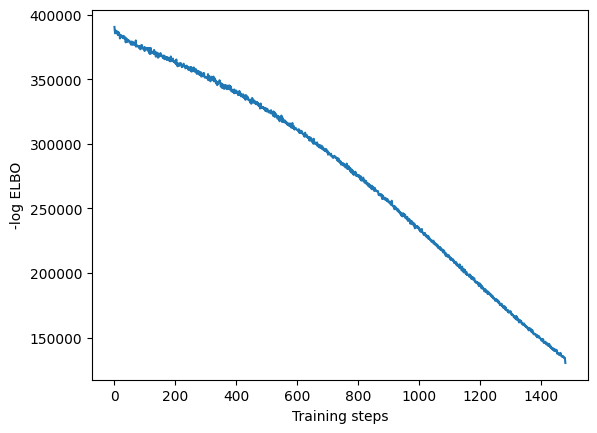

In [22]:
import ast
from re import sub
path = "data/bayesian_model_weights_full2/all_losses.txt"
with open(path) as json_file:
    all_losses = json_file.read()
    all_losses = sub('}{', '}, {', all_losses)
    all_losses = ast.literal_eval(all_losses)

import matplotlib.pyplot as plt
plt.plot(np.concatenate((all_losses[0]['epoch_1'], all_losses[1]['epoch_2'])));
plt.xlabel('Training steps');
plt.ylabel('-log ELBO');

# Predict

In [12]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'model_best.pth')))

<All keys matched successfully>

In [32]:
import random
predictor = AutosomePredictor(
    model=model, 
    model_pth=f'{model_dir}/model_best.pth', 
    device=torch.device(f"cuda:0"),
    use_reverse_channel=False,
    use_single_channel=False,
)
dna = "TGCATTTTTTTCACATC"+ ''.join(random.choice('ACGT') for _ in range(80)) + "GGTTACGGCTGTT"
predictor.predict(dna)

8.456583023071289

# Prediction on the test dataset

In [23]:
test_df = pd.read_csv('data/filtered_test_data_with_MAUDE_expression.txt', header=None, sep='\t')

In [33]:
from tqdm import tqdm
pred_expr = []
for seq in tqdm(test_df.iloc[:, 0]):
    pred_expr.append(predictor.predict(seq))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71103/71103 [10:19<00:00, 114.77it/s]


In [34]:
pred_expr = np.array(pred_expr)
pred_expr[np.isnan(pred_expr)] = 0

In [35]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(pred_expr, list(test_df.iloc[:, 1])), spearmanr(pred_expr, list(test_df.iloc[:, 1])))

PearsonRResult(statistic=-3.293564752878905e-05, pvalue=0.9929929210191463) SignificanceResult(statistic=0.004745171798975305, pvalue=0.20576672476792196)


# K-mer and CG baselines

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_scatter_pearson(
    prediction,
    test_df, 
    x_lab='Data',
    y_lab='Prediction (CG + GC)',
    
):

    x = list(test_df.iloc[:, 1])
    y = prediction

    # Calculate Pearson correlation coefficient
    corr = np.corrcoef(x, y)[0, 1]

    # Create a 2D histogram with logarithmic color scale
    bins = 50
    plt.hist2d(x, y, bins=bins, norm=mpl.colors.LogNorm())

    # Add labels and title
    plt.xlabel(f'{x_lab}')
    plt.ylabel(f'{y_lab}')
    plt.title(f'(Pearson Corr: {corr:.3f})')

    # Add a colorbar to show the scale
    plt.colorbar()

    # Display the plot
    plt.show()


PearsonRResult(statistic=0.38980258779441096, pvalue=0.0) SignificanceResult(statistic=0.39470918505119595, pvalue=0.0)


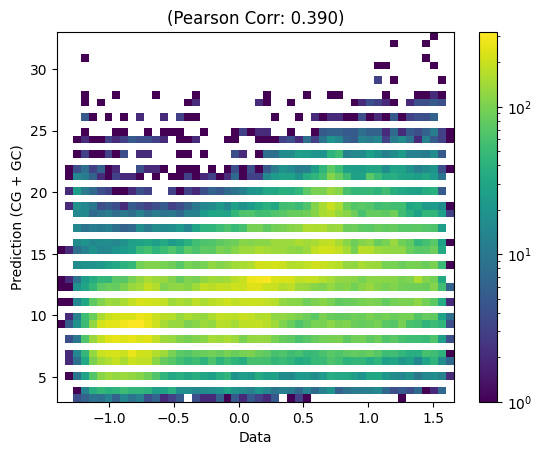

In [35]:
CG_baseline = test_df[0].str.count('CG') + test_df[0].str.count('GC')
CG_baseline = list(CG_baseline.values)

from scipy.stats import pearsonr, spearmanr
print(pearsonr(CG_baseline, list(test_df.iloc[:, 1])), spearmanr(CG_baseline, list(test_df.iloc[:, 1])))

plot_scatter_pearson(
    CG_baseline,
    test_df, 
    x_lab='Data',
    y_lab='Prediction (CG + GC)',
    
)

PearsonRResult(statistic=0.4798867375994707, pvalue=0.0) SignificanceResult(statistic=0.4844299552214177, pvalue=0.0)


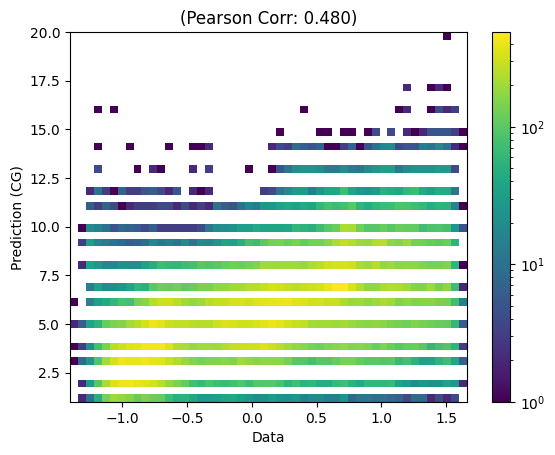

In [36]:
CG_baseline = test_df[0].str.count('CG')
CG_baseline = list(CG_baseline.values)

from scipy.stats import pearsonr, spearmanr
print(pearsonr(CG_baseline, list(test_df.iloc[:, 1])), spearmanr(CG_baseline, list(test_df.iloc[:, 1])))

plot_scatter_pearson(
    CG_baseline,
    test_df, 
    x_lab='Data',
    y_lab='Prediction (CG)',
    
)

PearsonRResult(statistic=0.38980258779441096, pvalue=0.0) SignificanceResult(statistic=0.39470918505119595, pvalue=0.0)


# Score your submission on DREAM Challenge test dataset

In [ ]:
# pred_expr = pd.read_csv('data/sample_submission.txt', sep = '\t', header = None).iloc[:,1]
from prixfixe.evaluation import evaluate_predictions
evaluate_predictions(pred_expr)